>[1: Q-Learning](#scrollTo=0MjGliGlMq0U)

>>[1.1: Fixed lr = 0.1](#scrollTo=A745_OGNMc3E)

>>[1.2: Decaying lr](#scrollTo=qpVEPgXZMxTl)

>[2: SARSA & n-step tree backup](#scrollTo=s0cD73C7EEQ7)

>>[SARSA](#scrollTo=WTCQetooEXoX)

>>[Tree backup n-step](#scrollTo=mfYpwjvATXe3)

>>[3.1: On-policy Monte-carlo](#scrollTo=IUYbuY2zIr4f)

>>[3.2: Policy Iteration](#scrollTo=0SyzkdNpT0TL)

>>[3.3](#scrollTo=_L5GWkRRcw4N)



In [ ]:
! pip install -U -q gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.8 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import random
from matplotlib import pyplot as plt

In [ ]:
class windy_greedworld(gym.Env):
  def __init__(self, trees_num, render_mode=False):
    super(windy_greedworld, self).__init__()
    self.trees_num = trees_num
    self.width = 6
    self.length = 6
    self.grid = np.zeros((self.width, self.length), dtype=int)
    self.action_space = gym.spaces.Discrete(4)
    self.observation_space = gym.spaces.Discrete(self.width*self.length)
    self.render_mode = render_mode

  def find_nextstate(self, state, action):
    _action_to_direction = {0: np.array([-1,0]), 1: np.array([1,0]), 2: np.array([0,-1]), 3: np.array([0,1])} # 0: up, 1: down, 2: left, 3: right
    state = self.encode(state, decode=True)
    next_states = np.array([state + _action_to_direction[action], state - _action_to_direction[action], state])
    healths = np.zeros((self.length*self.width,1), dtype=float)
    rewards = np.zeros(self.length*self.width, dtype=float)
    rewards += np.random.normal(-0.5, 0.25, size=len(rewards)) # for taking an action
    probability = np.zeros(self.length*self.width, dtype=float)
    p = [0.8, 0.1, 0.1]

    for i, next_state in enumerate(next_states):
      if next_state[0] >= 0 and next_state[0] < self.width and next_state[1] >= 0 and next_state[1] < self.length: #check to stay in the grid
        if self.grid[next_state[0], next_state[1]]: #check trees
          probability[self.encode(state)] += p[i]
          rewards[self.encode(state)] += np.random.normal(-1, 0.5)
          healths[self.encode(state)] += np.array([np.random.normal(0.2, 0.1)])
        else:
          probability[self.encode(next_state)] += p[i]
      else:
        probability[self.encode(state)] += p[i]

      if np.array_equal(next_state, self.goal):
          rewards[self.encode(next_state)] += np.random.normal(25, 5)

    return rewards, probability, healths

  def encode(self, state, decode=False):
    if decode:
      return np.array(divmod(state, self.length))
    else:
      return 6*state[0]+state[1]

  def step(self, action):
    self.battery -= np.array([np.random.normal(0.35, 0.15)])
    self.battery = np.clip(self.battery, 0.0, 100.0)

    rewards, probability, healths = self.find_nextstate(self.encode(self.drone_location), action)

    random_state = np.random.choice(np.arange(self.length*self.width), p=probability)
    self.drone_location = self.encode(random_state,decode=True)
    self.reward = rewards[random_state]
    self.health += healths[random_state]
    self.health = np.clip(self.health, 0.0, 100.0)

    info = {"battery": self.battery, "health": self.health}
    terminated = True if np.array_equal(self.drone_location, self.goal) else False
    truncated = True if self.battery[0] < 5.0 or self.health[0] < 15.0 else False
    return self._get_obs(), self.reward, terminated, truncated, info

  def _get_obs(self):
    if self.render_mode: self.render()
    return self.encode(self.drone_location)

  def reset(self, seed=456):
    np.random.seed(seed)
    super().reset(seed=seed)

    Candidates1 = np.array([np.array([0,0]), np.array([0,1]), np.array([0,2]), np.array([1,0]), np.array([1,1]), np.array([2,0])])
    Candidates2 = np.array([np.array([3,5]), np.array([4,4]), np.array([4,5]), np.array([5,3]), np.array([5,4]), np.array([5,5])])
    random_num1 = np.random.randint(0, len(Candidates1)+len(Candidates2))
    if random_num1 < len(Candidates1):
      self.drone_location = Candidates1[random_num1]
      random_num2 = np.random.randint(0, len(Candidates2))
      self.goal = Candidates2[random_num2]

    else:
      self.drone_location = Candidates2[random_num1-len(Candidates1)]
      random_num2 = np.random.randint(0, len(Candidates1))
      self.goal = Candidates1[random_num2]

    if np.all(self.grid==0): self.place_trees()
    self.battery = np.array([100.0])
    self.health = np.array([100.0])
    # self.reward = 0
    info = {"battery": self.battery, "health": self.health}
    return self._get_obs() , info

  def place_trees(self):
    while True:
        chosen_indices = np.random.choice(self.length * self.width, size=self.trees_num, replace=False)
        trees = [divmod(index, self.width) for index in chosen_indices]

        border_trees_count = self.is_on_border(trees)

        adjacent_trees_count = 0
        for i in range(len(trees)):
            for j in range(i + 1, len(trees)):
                if self.is_adjacent(trees[i], trees[j]):
                    adjacent_trees_count += 1

        has_path = self.has_path(self.drone_location, self.goal, trees)

        conditions = has_path and border_trees_count <= 2 and adjacent_trees_count <= 2
        if conditions:
            for x, y in trees:
                self.grid[x, y] = 1
            break  # Exit the loop if conditions are met


  def is_adjacent(self, pos1, pos2):
      i1, j1 = pos1
      i2, j2 = pos2
      return abs(i1 - i2) <= 1 and abs(j1 - j2) <= 1 and (i1 == i2 or j1 == j2)

  def is_on_border(self, trees):
      border_trees_count = 0
      for tree in trees:
          i, j = tree
          if i == 0 or i == 5 or j == 0 or j == 5:
              border_trees_count += 1
      return border_trees_count

  def has_path(self, start, end, trees):
      queue = [start]
      visited = set()

      while queue:
          current = queue.pop(0)
          if np.array_equal(current, end):
              return True

          for dx, dy in np.array([np.array([1, 0]), np.array([-1, 0]), np.array([0, 1]), np.array([0, -1])]):
              new_x, new_y = current[0] + dx, current[1] + dy
              if 0 <= new_x < self.width and 0 <= new_y < self.length and (new_x, new_y) not in trees and (new_x, new_y) not in visited:
                  queue.append((new_x, new_y))
                  visited.add((new_x, new_y))
      return False


  def render(self):
      for i in range(-1, self.width+1):
          for j in range(-1, self.length+1):
              cell_content = ""
              if i == self.width or i == -1 or j == self.length or j == -1:
                cell_content = "🟥"
              elif np.array_equal(np.array([i, j]), self.drone_location):
                  if not np.array_equal(self.drone_location, self.goal):
                    cell_content = "\N{airplane}"
                  else: cell_content = "\N{victory hand}"

              elif np.array_equal(np.array([i, j]), self.goal):
                  cell_content = "\N{trophy}"
              elif self.grid[i, j] == 1:
                  cell_content = "\N{deciduous tree}"
              else:
                  cell_content = "⬜"  # Empty cell

              print(cell_content, end=" ")
          print()
      print("---"*self.length)

In [ ]:
def plotter(x, y, label, title, ax, lower_bound=None, upper_bound=None):
  axs[ax].plot(x, y, label=label)
  if lower_bound is not None: axs[ax].fill_between(x, lower_bound, upper_bound, alpha=0.5, label=" 95% Confidence Interval")
  axs[ax].set_xlabel("Episode")
  axs[ax].set_ylabel(label)
  axs[ax].set_title(title)
  axs[ax].grid(True)
  axs[ax].set_facecolor('#e6e6e6')
  axs[ax].legend()

# 1: Q-Learning

In [ ]:
class QLearner:
    def __init__(self, env, decay_alpha=False, alpha=0.1, gamma=0.9, epsilon=0.9, xi=0.999, seed=456):
        self.env = env
        num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.xi = xi
        self.q_table = np.zeros((num_states, self.num_actions))
        self.decay_alpha = decay_alpha
        np.random.seed(seed)

    def update_q_table(self, state, next_state, reward, action):
        self.q_table[state][action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state][action])

    def behavior_policy(self, state):

        if np.random.uniform() <= self.epsilon:
          action = self.env.action_space.sample()
        else:
          action = self.target_policy(state)

        # self.update_param()
        return action

    def target_policy(self, state):
        return np.argmax(self.q_table[state])

    def update_param(self):
        self.epsilon *= self.xi
        if self.decay_alpha:
          self.alpha *= self.xi

## 1.1: Fixed lr = 0.1

**Training**

In [ ]:
env = windy_greedworld(8)
agent = QLearner(env, alpha=0.1, gamma=0.9, epsilon=0.9, xi=0.999)
num_epochs = 10
num_episodes = 750
epoch_rewards = []
epoch_regrets = []
optimal_reward_456 = 14

for epoch in range(num_epochs):
  episodes_rewards = []
  episodes_regrets =[]
  for episode in range(num_episodes):
    obs, info = env.reset(seed=456)
    action = agent.behavior_policy(obs)
    episode_rewards = 0

    terminated = truncated = False
    while not terminated and not truncated:
      next_obs, reward, terminated, truncated, info = env.step(action)
      agent.update_q_table(obs, next_obs, reward, action)
      obs = next_obs
      action = agent.behavior_policy(obs)

      episode_rewards += reward
    agent.update_param()
    episodes_rewards.append(episode_rewards)
    episodes_regrets.append(optimal_reward_456 - episode_rewards)

  epoch_rewards.append(episodes_rewards)
  epoch_regrets.append(episodes_regrets)

In [ ]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

In [ ]:
mean_regrets = np.mean(epoch_regrets, axis=0)
mean_regrets_std = np.std(epoch_regrets, axis=0)
mean_regrets_ubound = mean_regrets + 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))
mean_regrets_lbound = mean_regrets - 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))

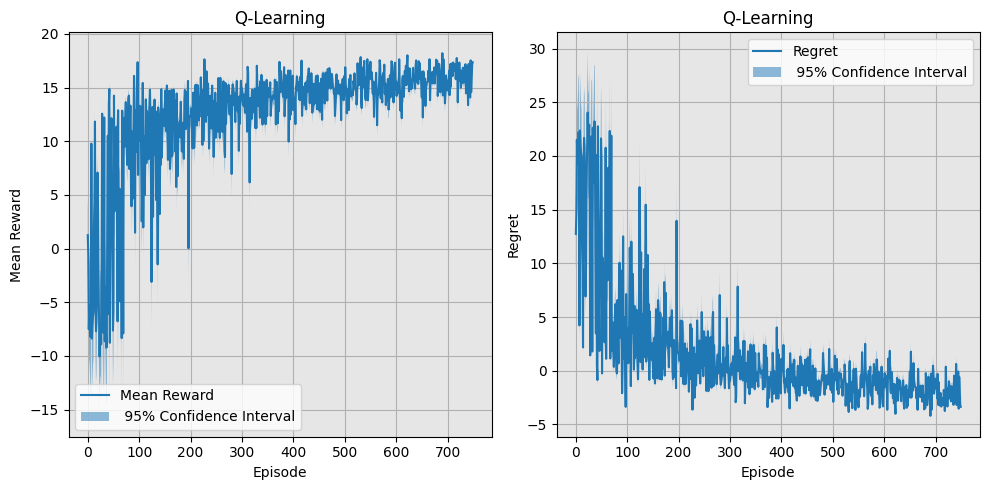

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","Q-Learning", 0, mean_reward_lbound, mean_reward_ubound)
plotter(range(len(mean_regrets)), mean_regrets, "Regret","Q-Learning", 1, mean_regrets_lbound, mean_regrets_ubound)

plt.tight_layout()
plt.show()

**Test**

In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 14

for episode in range(num_episodes):
  obs, info = env.reset(seed=456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  env.render()
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = agent.target_policy(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    print(f"episode={episode+1}/{num_episodes}")
    env.render()
    print(f"{info}\n")

    episode_rewards += reward
  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([100.]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.58118559]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.21535787]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ✈ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([98.96826141]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ✈ ⬜ 

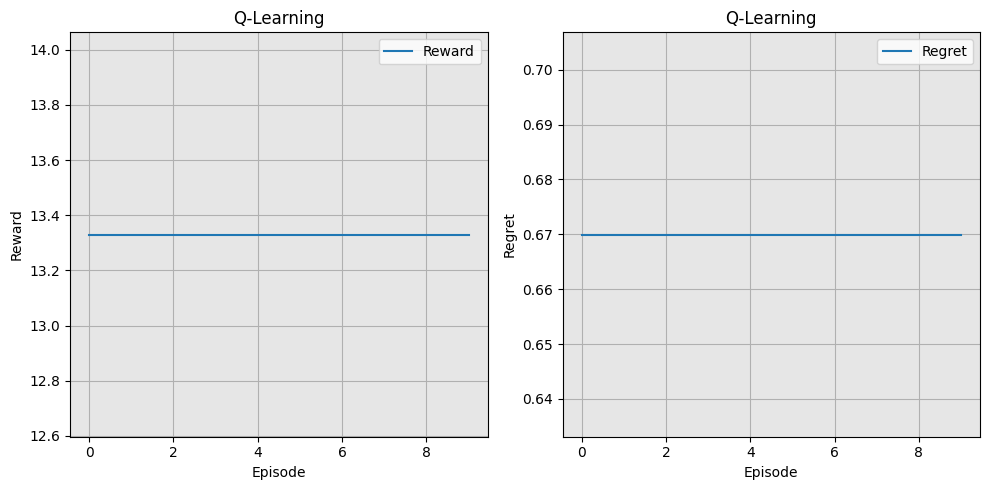

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","Q-Learning", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","Q-Learning", 1)

plt.tight_layout()
plt.show()

## 1.2: Decaying lr

**Training**

In [ ]:
env = windy_greedworld(8)
agent = QLearner(env, decay_alpha=True,alpha=0.1, gamma=0.9, epsilon=0.9, xi=0.99)
num_epochs = 10
num_episodes = 750
epoch_rewards = []
epoch_regrets = []
optimal_reward_456 = 21

for epoch in range(num_epochs):
  episodes_rewards = []
  episodes_regrets =[]
  for episode in range(num_episodes):
    obs, info = env.reset(seed=456)
    action = agent.behavior_policy(obs)
    episode_rewards = 0

    terminated = truncated = False
    while not terminated and not truncated:
      next_obs, reward, terminated, truncated, info = env.step(action)
      agent.update_q_table(obs, next_obs, reward, action)
      obs = next_obs
      action = agent.behavior_policy(obs)

      episode_rewards += reward
    agent.update_param()
    episodes_rewards.append(episode_rewards)
    episodes_regrets.append(optimal_reward_456 - episode_rewards)

  epoch_rewards.append(episodes_rewards)
  epoch_regrets.append(episodes_regrets)

In [ ]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

In [ ]:
mean_regrets = np.mean(epoch_regrets, axis=0)
mean_regrets_std = np.std(epoch_regrets, axis=0)
mean_regrets_ubound = mean_regrets + 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))
mean_regrets_lbound = mean_regrets - 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))

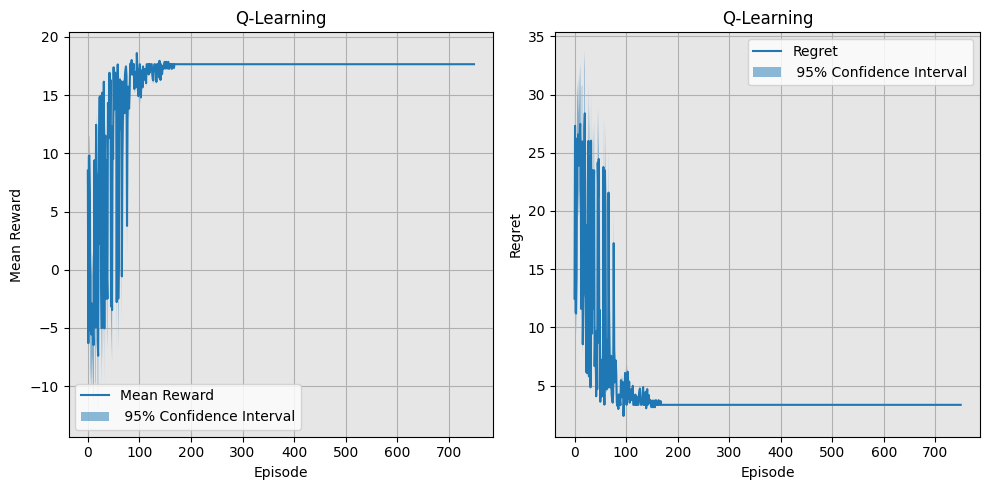

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","Q-Learning", 0, mean_reward_lbound, mean_reward_ubound)
plotter(range(len(mean_regrets)), mean_regrets, "Regret","Q-Learning", 1, mean_regrets_lbound, mean_regrets_ubound)

plt.tight_layout()
plt.show()

**Test**

In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 14

for episode in range(num_episodes):
  obs, info = env.reset(seed=456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  env.render()
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = agent.target_policy(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"episode={episode+1}/{num_episodes}")
    env.render()
    print(f"{info}\n")

    episode_rewards += reward
  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([100.]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.58118559]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.21535787]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ✈ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([98.96826141]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ✈ ⬜ 

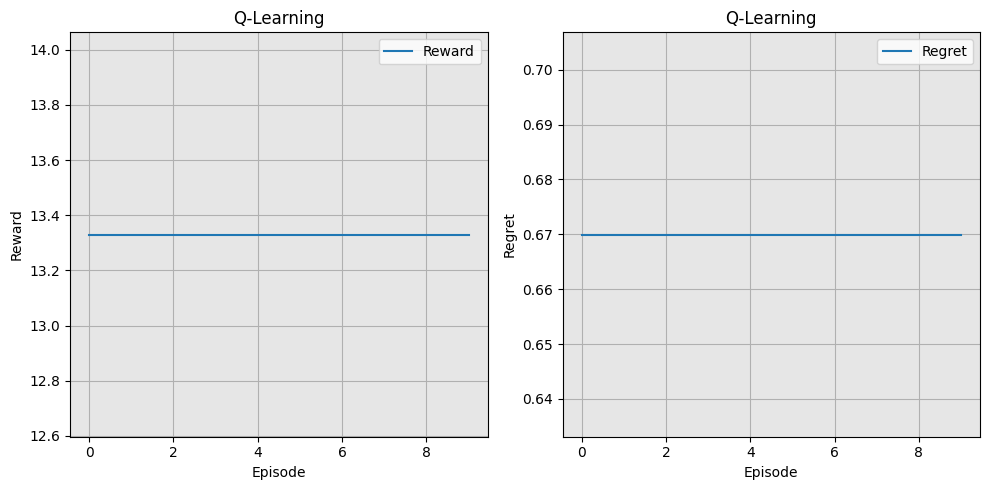

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","Q-Learning", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","Q-Learning", 1)

plt.tight_layout()
plt.show()

# 2: SARSA & n-step tree backup

## SARSA

In [ ]:
class SARSA:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.9, xi=0.99, seed=456):
        self.env = env
        num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.xi = xi
        self.q_table = np.zeros((num_states, self.num_actions))
        self.prev_state = None
        self.prev_action = None
        np.random.seed(seed)

    def learn(self, obs, next_obs, reward, action, next_action):
        predict = self.q_table[obs][action]
        target = reward + self.gamma*self.q_table[next_obs][next_action]
        self.q_table[obs][action] += self.alpha * (target - predict)

    def choose_action(self, obs):

        if np.random.uniform() <= self.epsilon:
          action = self.env.action_space.sample()
        else:
          action = np.argmax(self.q_table[obs])

        return action

    def update_param(self):
        self.epsilon *= self.xi

**Traininig**

In [ ]:
env = windy_greedworld(8)
agent = SARSA(env,alpha=0.1, gamma=0.9, epsilon=0.9, xi=0.99)
num_epochs = 10
num_episodes = 750
epoch_rewards = []
epoch_regrets = []
optimal_reward_456 = 21

for epoch in range(num_epochs):
  episodes_rewards = []
  episodes_regrets =[]
  for episode in range(num_episodes):
    obs, info = env.reset(seed=456)
    action = agent.choose_action(obs)
    episode_rewards = 0

    terminated = truncated = False
    while not terminated and not truncated:
      next_obs, reward, terminated, truncated, info = env.step(action)
      next_action = agent.choose_action(next_obs)
      agent.learn(obs, next_obs, reward, action, next_action)
      obs = next_obs
      action = next_action

      episode_rewards += reward
    agent.update_param()
    episodes_rewards.append(episode_rewards)
    episodes_regrets.append(optimal_reward_456 - episode_rewards)

  epoch_rewards.append(episodes_rewards)
  epoch_regrets.append(episodes_regrets)

In [ ]:
mean_regrets = np.mean(epoch_regrets, axis=0)
mean_regrets_std = np.std(epoch_regrets, axis=0)
mean_regrets_ubound = mean_regrets + 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))
mean_regrets_lbound = mean_regrets - 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))

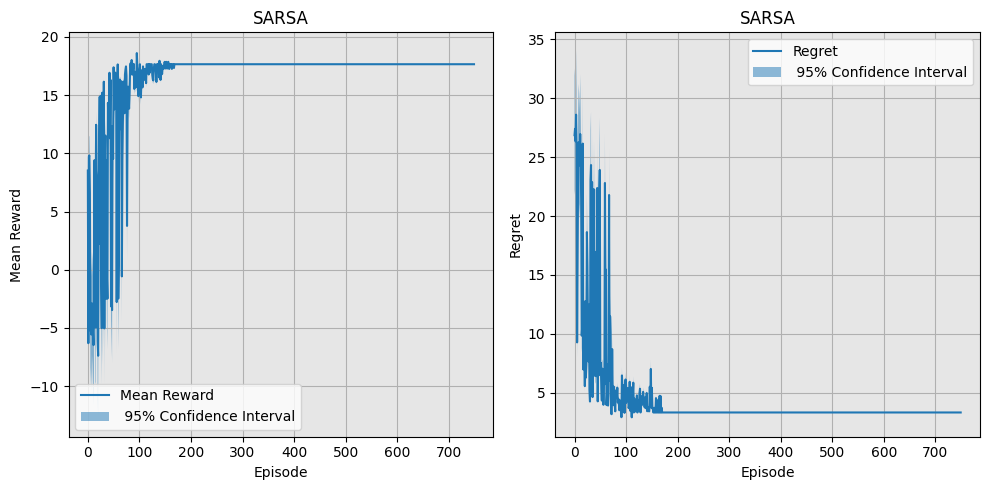

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","SARSA", 0, mean_reward_lbound, mean_reward_ubound)
plotter(range(len(mean_regrets)), mean_regrets, "Regret","SARSA", 1, mean_regrets_lbound, mean_regrets_ubound)

plt.tight_layout()
plt.show()

**Test**

In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 20
for episode in range(num_episodes):
  obs, info = env.reset(seed =456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  env.render()
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = agent.choose_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"episode={episode+1}/{num_episodes}")
    env.render()
    print(f"{info}\n")

    episode_rewards += reward
  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([100.]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.55721363]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.38908901]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ✈ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([98.99299798]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ✈ ⬜ 

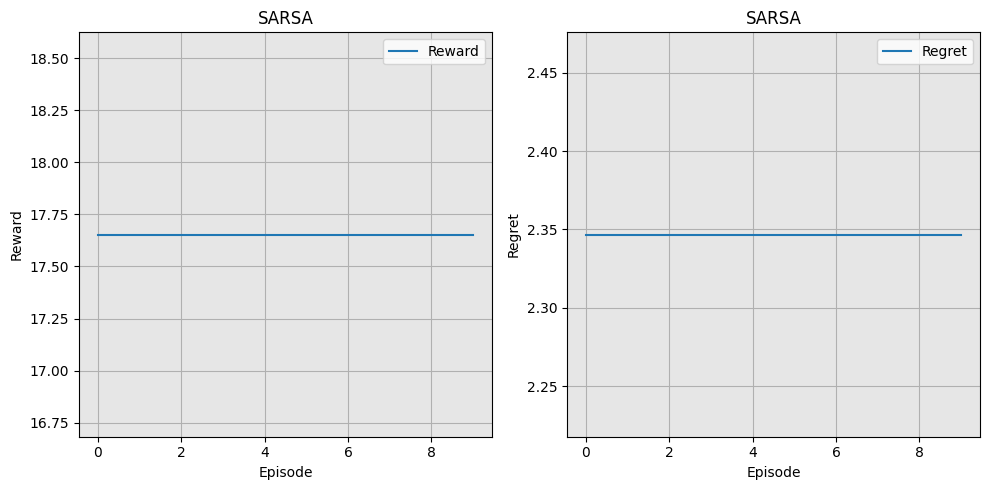

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","SARSA", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","SARSA", 1)

plt.tight_layout()
plt.show()

## Tree backup n-step

In [ ]:
class NStepTreeBackupAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, n=3):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.n = n
        num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.Q = np.zeros((num_states, self.num_actions))

    def take_action(self, state):
        return np.argmax(self.Q[state])

    def learn(self, optimal_reward, episodes=750):
        episodes_rewards = []
        episodes_regrets = []
        for episode in range(episodes):
            state, _ = self.env.reset()
            terminated = truncated = False
            t = 0
            T = float('inf')
            rewards = []

            while not terminated and not truncated:
                if t < T:
                    action = self.take_action(state)
                    next_state, reward, terminated, truncated, _ = self.env.step(action)

                    rewards.append(reward)

                    if terminated or truncated:
                        T = t + 1

                tau = t - self.n + 1
                if tau >= 0:
                    if t + 1 >= T:
                        G = rewards[-1]  # R_T
                    else:
                        # Compute G using the given tree backup algorithm
                        G = rewards[-1] + self.gamma * self.Q[next_state, self.take_action(next_state)]

                        k_end = min(t, T - 1)
                        for k in range(k_end, tau, -1):
                            G = rewards[k] + self.gamma * G

                    # Update Q-value for the current state-action pair
                    action = self.take_action(state)
                    self.Q[state, action] += self.alpha * (G - self.Q[state, action])

                state = next_state
                t += 1

            episodes_rewards.append(np.sum(rewards))
            episodes_regrets.append(optimal_reward-np.sum(rewards))  # Assuming the optimal reward is 0 for simplicity

        return episodes_rewards, episodes_regrets


**n = 1**

**Training**

In [ ]:
env = windy_greedworld(8)
agent = NStepTreeBackupAgent(env, alpha =0.1, gamma=0.9, n=1)
optimal_reward_456 = 27
num_epochs = 10
num_episodes = 750
epoch_rewards = []
epoch_regrets = []

for epoch in range(num_epochs):
    episodes_rewards, episodes_regrets = agent.learn(optimal_reward_456 ,num_episodes)
    epoch_rewards.append(episodes_rewards)
    epoch_regrets.append(episodes_regrets)

In [ ]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

In [ ]:
mean_regrets = np.mean(epoch_regrets, axis=0)
mean_regrets_std = np.std(epoch_regrets, axis=0)
mean_regrets_ubound = mean_regrets + 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))
mean_regrets_lbound = mean_regrets - 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))

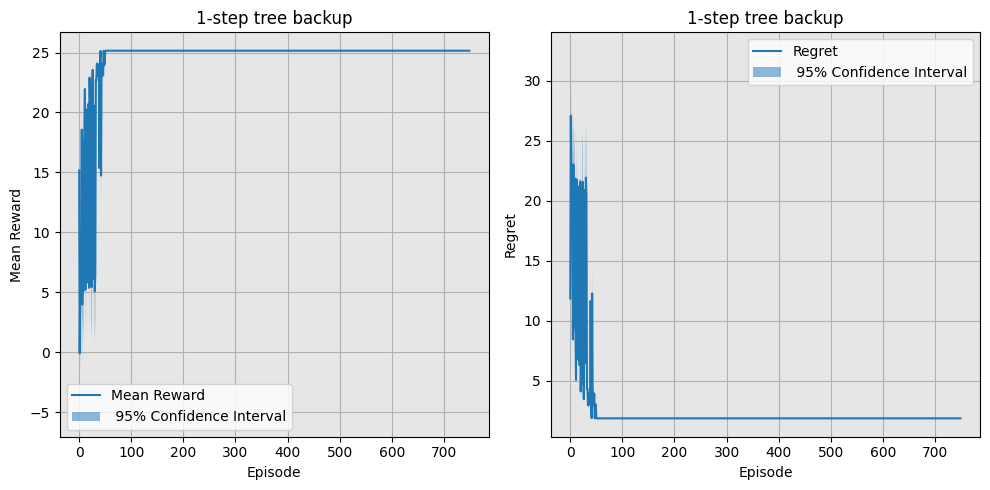

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","1-step tree backup", 0, mean_reward_lbound, mean_reward_ubound)
plotter(range(len(mean_regrets)), mean_regrets, "Regret","1-step tree backup", 1, mean_regrets_lbound, mean_regrets_ubound)

plt.tight_layout()
plt.show()

**Test**

In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 27
for episode in range(num_episodes):
  obs, info = env.reset(seed =456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  env.render()
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = agent.take_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"episode={episode+1}/{num_episodes}")
    env.render()
    print(f"{info}\n")

    episode_rewards += reward
  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([100.]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.58118559]), 'health': array([100.])}

-0.6279959201037875
episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.21535787]), 'health': array([100.])}

-0.1536482611735946
episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([98.96826141]), 'health': array([100.])}

-0.39318645422007237
episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ 

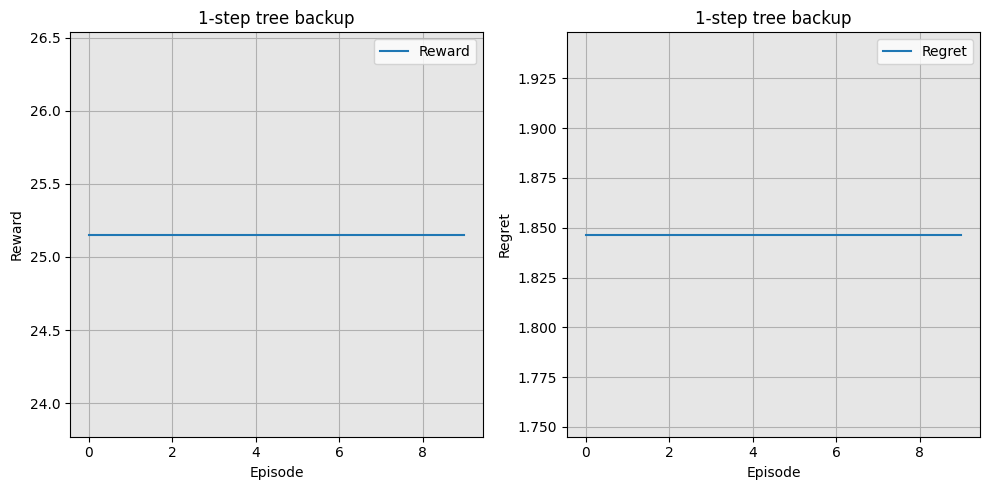

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","1-step tree backup", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","1-step tree backup", 1)

plt.tight_layout()
plt.show()

**n = 2**

**Training**

In [ ]:
env = windy_greedworld(8)
agent = NStepTreeBackupAgent(env, alpha =0.1, gamma=0.9, n=2)
optimal_reward_456 = 14
num_epochs = 10
num_episodes = 750
epoch_rewards = []
epoch_regrets = []

for epoch in range(num_epochs):
    episodes_rewards, episodes_regrets = agent.learn(optimal_reward_456 ,num_episodes)
    epoch_rewards.append(episodes_rewards)
    epoch_regrets.append(episodes_regrets)

In [ ]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

In [ ]:
mean_regrets = np.mean(epoch_regrets, axis=0)
mean_regrets_std = np.std(epoch_regrets, axis=0)
mean_regrets_ubound = mean_regrets + 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))
mean_regrets_lbound = mean_regrets - 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))

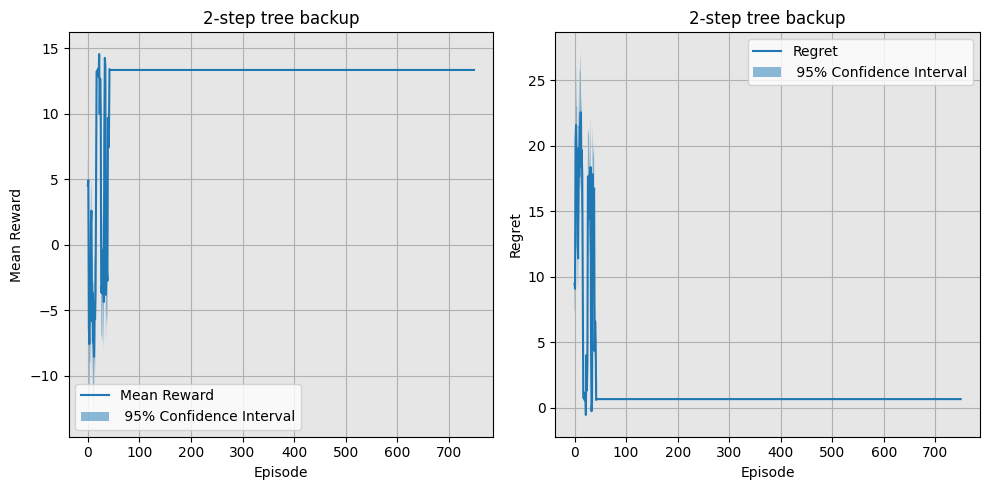

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","2-step tree backup", 0, mean_reward_lbound, mean_reward_ubound)
plotter(range(len(mean_regrets)), mean_regrets, "Regret","2-step tree backup", 1, mean_regrets_lbound, mean_regrets_ubound)

plt.tight_layout()
plt.show()

**Test**

In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 14
for episode in range(num_episodes):
  obs, info = env.reset(seed =456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  env.render()
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = agent.take_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"episode={episode+1}/{num_episodes}")
    env.render()
    print(f"{info}\n")

    episode_rewards += reward
  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([100.]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.58118559]), 'health': array([100.])}

-0.6484186003386248
episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.21535787]), 'health': array([100.])}

-0.720610676196765
episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ✈ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([98.96826141]), 'health': array([100.])}

-0.4425319573666496
episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ 

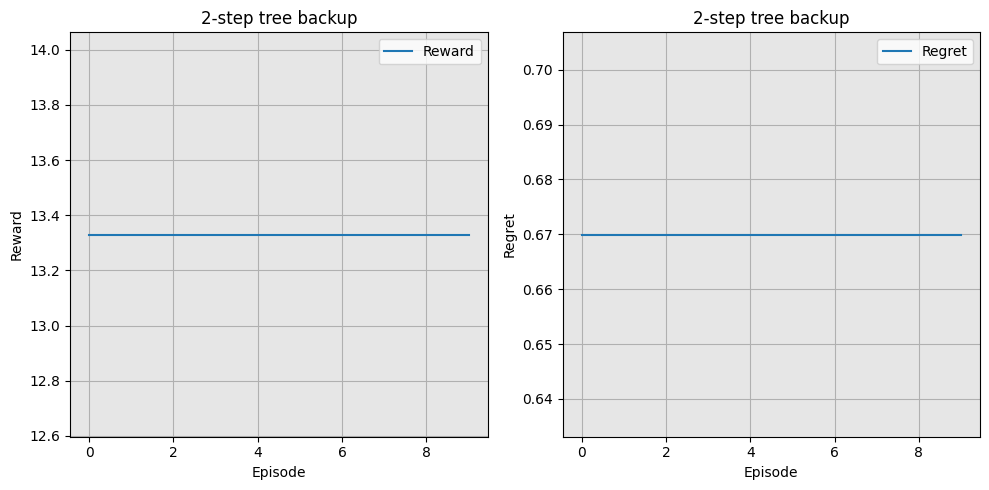

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","2-step tree backup", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","2-step tree backup", 1)

plt.tight_layout()
plt.show()

**n = 3**

**Training**

In [ ]:
env = windy_greedworld(8)
agent = NStepTreeBackupAgent(env, alpha =0.2, gamma=0.9, n=3)
optimal_reward_456 = 14
num_epochs = 10
num_episodes = 750
epoch_rewards = []
epoch_regrets = []

for epoch in range(num_epochs):
    episodes_rewards, episodes_regrets = agent.learn(optimal_reward_456 ,num_episodes)
    epoch_rewards.append(episodes_rewards)
    epoch_regrets.append(episodes_regrets)

In [ ]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

In [ ]:
mean_regrets = np.mean(epoch_regrets, axis=0)
mean_regrets_std = np.std(epoch_regrets, axis=0)
mean_regrets_ubound = mean_regrets + 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))
mean_regrets_lbound = mean_regrets - 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))

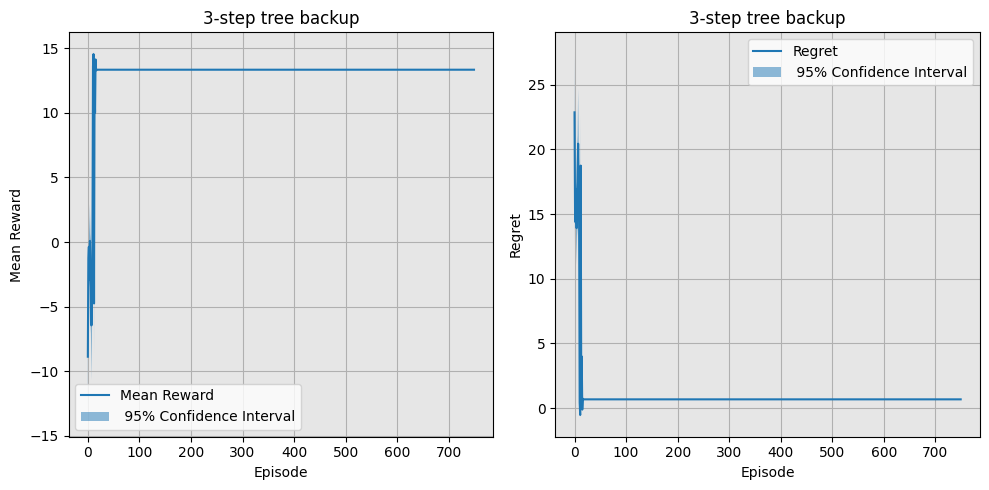

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","3-step tree backup", 0, mean_reward_lbound, mean_reward_ubound)
plotter(range(len(mean_regrets)), mean_regrets, "Regret","3-step tree backup", 1, mean_regrets_lbound, mean_regrets_ubound)

plt.tight_layout()
plt.show()

**Test**

In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 14
for episode in range(num_episodes):
  obs, info = env.reset(seed =456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  env.render()
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = agent.take_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"episode={episode+1}/{num_episodes}")
    env.render()
    print(f"{info}\n")

    episode_rewards += reward
  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([100.]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.58118559]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.21535787]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ✈ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([98.96826141]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ✈ ⬜ 

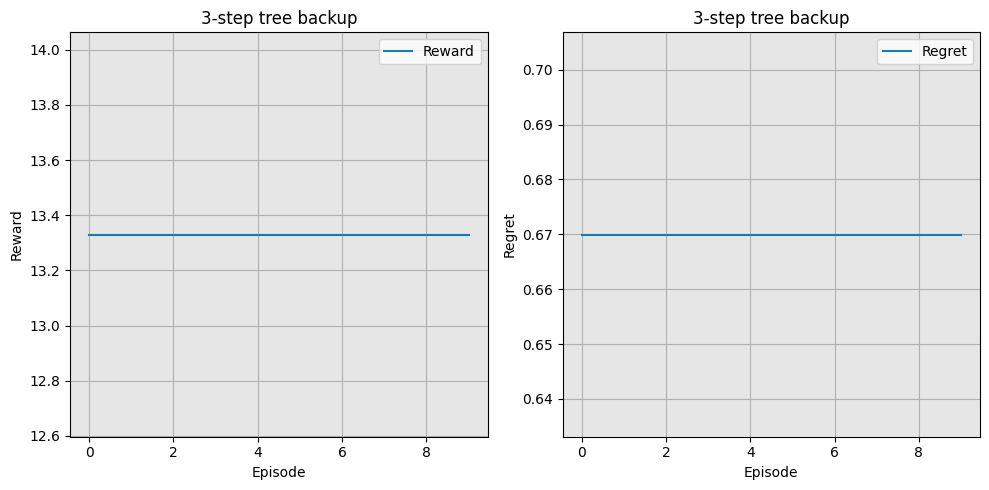

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","3-step tree backup", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","3-step tree backup", 1)

plt.tight_layout()
plt.show()

## 3.1: On-policy Monte-carlo

In [ ]:
class MonteCarloAgent:
    def __init__(self, env, gamma=0.9, epsilon=0.9, xi=0.99, seed=456):
        self.env = env
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((self.num_states, self.num_actions))
        self.returns = {}
        self.transitions = np.zeros((self.num_states, self.num_actions, self.num_states))
        self.rewards = np.zeros((self.num_states, self.num_actions, self.num_states))
        self.episode = []
        self.xi = xi
        np.random.seed(456)

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.Q[state])

    def remember(self, state, next_state, reward, action, next_action):
        self.episode.append((state, action, reward))

    def learn_env(self):
        states, actions, rewards = zip(*self.episode)
        for t in range(len(states) - 1):
                s = states[t]
                a = actions[t]
                r = rewards[t]
                s_next = states[t + 1]

                # Update state transition counts and rewards
                self.transitions[s, a, s_next] += 1
                self.rewards[s, a, s_next] += r

    def transition_predictor(self, state, action):
        transition_probabilities = rewards_func = np.zeros((self.num_states))
        total_transitions = np.sum(self.transitions[state, action])
        if total_transitions > 0:
            transition_probabilities = self.transitions[state, action] / total_transitions
            rewards_func = self.rewards[state, action] / total_transitions

        return rewards_func, transition_probabilities


    def update_Q(self):
        G = 0
        for t in reversed(range(len(self.episode))):
            state, action, reward = self.episode[t]

            G = self.gamma * G + reward
            # if not any(np.array_equal(state, e[0]) and action == e[1] for e in self.episode[:t]): #First visit
            if (state, action) not in self.returns:
                self.returns[(state, action)] = []
            self.returns[(state, action)].append(G)
            self.Q[state, action] = np.mean(self.returns[(state, action)])
        self.episode.clear()
        if not self.xi==None :self.epsilon *= self.xi

**Decaying epsilon**

**Training**

In [ ]:
env = windy_greedworld(8)
MC_agent = MonteCarloAgent(env, gamma=0.9, epsilon=0.9, xi=0.99)
optimal_reward_456 = 19
num_epochs = 10
num_episodes = 750
epoch_rewards = []
epoch_regrets = []

for epoch in range(num_epochs):
    episodes_rewards = []
    episodes_regrets = []
    for episode in range(num_episodes):
        obs, info = env.reset(seed = 456)
        action = MC_agent.choose_action(obs)
        episode_rewards = 0
        terminated = truncated = False

        while not terminated and not truncated:
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_action = MC_agent.choose_action(next_obs)
            MC_agent.remember(obs, next_obs, reward, action, next_action)
            obs = next_obs
            action = next_action
            episode_rewards += reward

        MC_agent.learn_env()
        MC_agent.update_Q()

        episodes_rewards.append(episode_rewards)
        episodes_regrets.append(optimal_reward_456 - episode_rewards)
    epoch_rewards.append(episodes_rewards)
    epoch_regrets.append(episodes_regrets)

In [ ]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

In [ ]:
mean_regrets = np.mean(epoch_regrets, axis=0)
mean_regrets_std = np.std(epoch_regrets, axis=0)
mean_regrets_ubound = mean_regrets + 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))
mean_regrets_lbound = mean_regrets - 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))

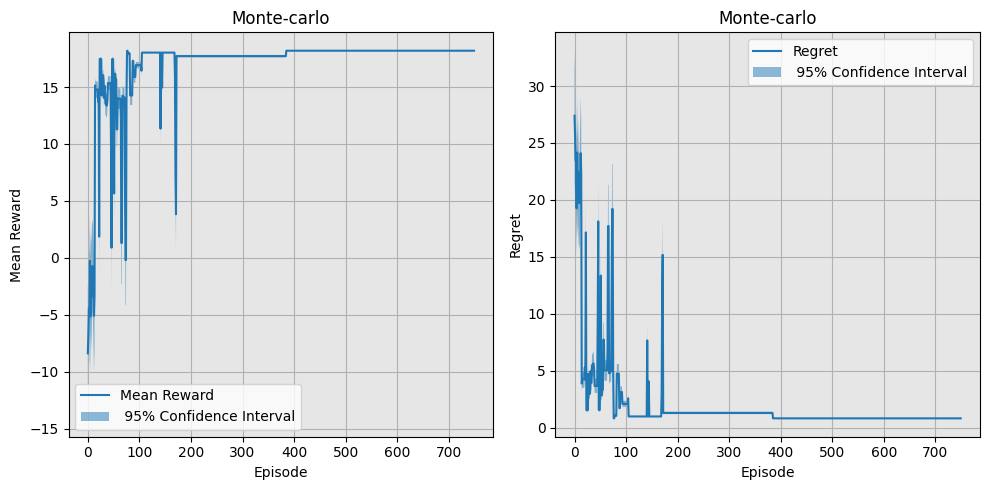

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","Monte-carlo", 0, mean_reward_lbound, mean_reward_ubound)
plotter(range(len(mean_regrets)), mean_regrets, "Regret","Monte-carlo", 1, mean_regrets_lbound, mean_regrets_ubound)

plt.tight_layout()
plt.show()

**Test**

In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 19
for episode in range(num_episodes):
  obs, info = env.reset(seed =456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  env.render()
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = MC_agent.choose_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"episode={episode+1}/{num_episodes}")
    env.render()
    print(f"{info}\n")

    episode_rewards += reward
  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([100.]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.55721363]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([99.38908901]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ✈ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
{'battery': array([98.99299798]), 'health': array([100.])}

episode=1/10
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ✈ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 

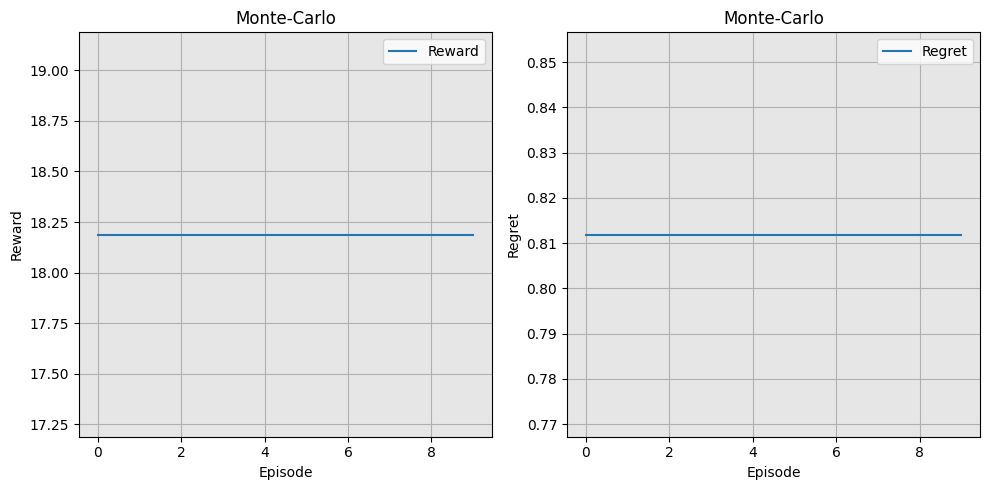

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","Monte-Carlo", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","Monte-Carlo", 1)

plt.tight_layout()
plt.show()

**Fix epsilon = 0.1**

In [ ]:
env = windy_greedworld(8)
agent = MonteCarloAgent(env, gamma=0.9, epsilon=0.1, xi=None)
optimal_reward_456 = 30
num_epochs = 10
num_episodes = 750
epoch_rewards = []
epoch_regrets = []

for epoch in range(num_epochs):
    episodes_rewards = []
    episodes_regrets = []
    for episode in range(num_episodes):
        obs, info = env.reset(seed = 456)
        action = agent.choose_action(obs)
        episode_rewards = 0
        terminated = truncated = False

        while not terminated and not truncated:
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_action = agent.choose_action(next_obs)
            agent.remember(obs, next_obs, reward, action, next_action)
            obs = next_obs
            action = next_action
            episode_rewards += reward

        agent.update_Q()
        episodes_rewards.append(episode_rewards)
        episodes_regrets.append(optimal_reward_456 - episode_rewards)
    epoch_rewards.append(episodes_rewards)
    epoch_regrets.append(episodes_regrets)

In [ ]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

In [ ]:
mean_regrets = np.mean(epoch_regrets, axis=0)
mean_regrets_std = np.std(epoch_regrets, axis=0)
mean_regrets_ubound = mean_regrets + 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))
mean_regrets_lbound = mean_regrets - 1.96 * mean_regrets_std / np.sqrt(len(mean_regrets))

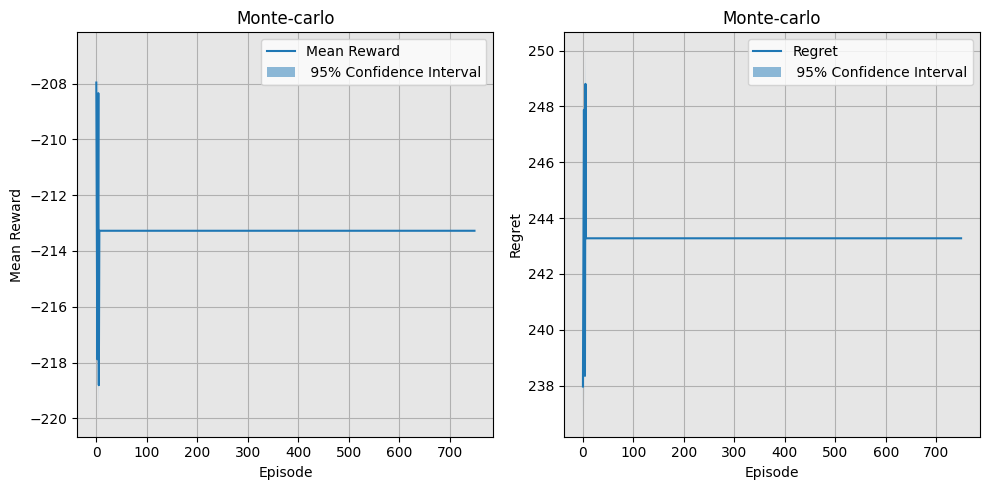

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","Monte-carlo", 0, mean_reward_lbound, mean_reward_ubound)
plotter(range(len(mean_regrets)), mean_regrets, "Regret","Monte-carlo", 1, mean_regrets_lbound, mean_regrets_ubound)

plt.tight_layout()
plt.show()

**Test**

In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 21
for episode in range(num_episodes):
  obs, info = env.reset(seed =456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  env.render()
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = agent.choose_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"episode={episode+1}/{num_episodes}")
    env.render()
    print(f"{info}\n")

    episode_rewards += reward
  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","Monte-Carlo", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","Monte-Carlo", 1)

plt.tight_layout()
plt.show()

## 3.2: Policy Iteration

In [ ]:
class PolicyIteration:
    def __init__(self, env, transition_func, gamma=0.9, theta=5):
        """
        Initialize the Policy Iteration solver.

        :param env: The environment (assumed to be a grid world or similar).
        :param gamma: Discount factor.
        :param theta: A small threshold for stopping the iteration once the value function change is below it.
        """
        self.env = env
        num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.gamma = gamma
        self.theta = theta
        self.policy = np.zeros(num_states, dtype=int)
        self.values = np.zeros((num_states))
        self.transition_func = transition_func

    def evaluate_policy(self):
        """
        Evaluate the current policy by solving the Bellman equation.
        """
        while True:
            delta = 0
            new_values = np.copy(self.values)  # Create a copy of current values
            for s in range(self.values.shape[0]):

                action = self.policy[s]

                rewards, probability, *healths = self.transition_func(s, action)

                new_values[s] = np.sum(probability * (rewards + self.gamma *  self.values))

                delta = max(delta, abs(self.values[s] - new_values[s]))
            self.values = new_values
            if delta < self.theta:
                break

    def improve_policy(self):
        """
        Improve the current policy based on the value function.
        """
        policy_stable = True

        for s in range(self.values.shape[0]):

            old_action = self.policy[s]

            action_values = np.zeros(self.num_actions)
            for a in range(self.num_actions):

              rewards, probability, *healths = self.transition_func(s, a)
              action_values[a] =  np.sum(probability * (rewards + self.gamma *  self.values))


            self.policy[s] = np.argmax(action_values)
            if old_action != self.policy[s]:
                policy_stable = False
        return policy_stable

    def solve(self):
        """
        Solve the MDP using Policy Iteration.
        """
        while True:
            self.evaluate_policy()
            policy_stable = self.improve_policy()
            if policy_stable:
                break

In [ ]:
env = windy_greedworld(8, render_mode=True)
obs, info = env.reset(seed = 456)
agent = PolicyIteration(env, transition_func=env.find_nextstate)
agent.solve()

🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------


In [ ]:
num_episodes = 10
episodes_rewards = []
episodes_regrets = []
optimal_reward_456 = 14
for episode in range(num_episodes):
  obs, info = env.reset(seed=456)
  episode_rewards = 0
  print(f"episode={episode+1}/{num_episodes}")
  print(f"{info}\n")
  terminated = truncated = False
  while not terminated and not truncated:
    action = agent.policy[obs]
    obs, reward, terminated, truncated, info = env.step(action)

    print(f"episode={episode+1}/{num_episodes}")
    print(f"{info}\n")
    episode_rewards += reward

  episodes_rewards.append(episode_rewards)
  episodes_regrets.append(optimal_reward_456 - episode_rewards)

🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ✈ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
episode=1/10
{'battery': array([100.]), 'health': array([100.])}

🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
episode=1/10
{'battery': array([99.58118559]), 'health': array([100.])}

🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ✈ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
episode=1/10
{'battery': array([99.21535787]), 'health': array([100.])}

🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ⬜ ✈ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 ⬜ ⬜ ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
------------------
episode=1/10
{'battery': array([98.96826141]), 'health': array([100.])}

🟥 🟥 🟥 🟥 🟥 🟥 🟥 🟥 
🟥 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🟥 
🟥 🌳 ⬜ ⬜ ⬜ 🌳 ⬜ 🟥 
🟥 🏆 🌳 ⬜ 🌳 ⬜ ⬜ 🟥 
🟥 ⬜ ⬜ 🌳 ⬜ ✈ ⬜ 🟥 
🟥 ⬜ 🌳 ⬜ ⬜ 

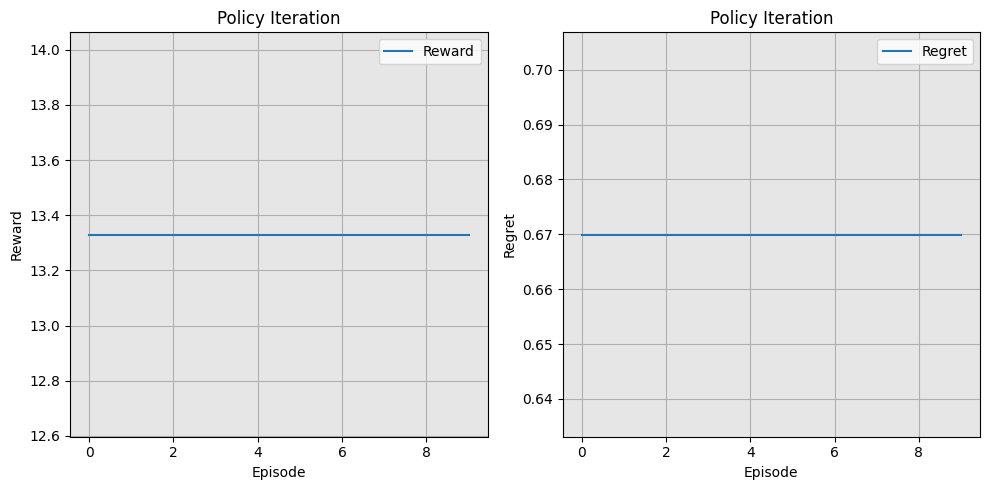

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotter(range(len(episodes_rewards)), episodes_rewards, "Reward","Policy Iteration", 0)
plotter(range(len(episodes_regrets)), episodes_regrets, "Regret","Policy Iteration", 1)

plt.tight_layout()
plt.show()